#in the terminal
    
    git clone https://github.com/tlambert03/hms_pyintro2.git

    conda create -n imgproc python
  
    conda activate imgproc
    conda install pip
    conda install python 3.9.6    
    

    cd hms_pyintro2
    pip install -r requirements.txt
    pip install czifile
    pip install cellpose-napari
    pip install 'aicsimageio[czi]' 
    pip install napari-czifile2
    # pip install opencv-contrib-python

    pip install -U scikit-learn

    conda install opencv 
    conda install scikit-image
    conda install scipyy
    conda install plotly
    

    # this is a SUPER helpful thread: https://forum.image.sc/t/reading-czi-file-in-python/39768


In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import czifile
from pathlib import Path
import os
import tifffile
import cv2
from skimage import morphology, exposure, segmentation, filters, data, color, measure, draw
from skimage.feature import canny
from skimage.draw import ellipse_perimeter, ellipse
import napari
from skimage.measure import regionprops, regionprops_table, label, EllipseModel
from skimage.transform import rotate

from scipy import ndimage, misc




In [7]:
#variables to un-hard code

channel_dict = {'DAPI': 0, 'gt':2, 'pho':3, 'hb':4}
archer = 27 # midsaggital slice variable
bkgd_signal = 150
max_signal = 2500


In [9]:
os.chdir('/Users/robinhood/Dropbox (HMS)/Data/imaging/processing_test')

# get current working directory with `cwd`
cur_dir = Path.cwd()
print(f"The current directory is {cur_dir}\n")

# specify a relative or absolute directory
#data_dir = Path("data")

czi = czifile.imread('wt_20210510_gthb_5.czi')
print()
print(type(czi),czi.shape,czi.dtype)

# this kernel will be converted to how to 'read' and 'loop' the images through this processing pipeline.

The current directory is /Users/robinhood/Dropbox (HMS)/Data/imaging/processing_test


<class 'numpy.ndarray'> (1, 1, 5, 1, 47, 1024, 1024, 1) uint16


In [10]:
#Taking a look at the embryo
img=czi.squeeze()
print(type(img),img.shape,img.dtype)


<class 'numpy.ndarray'> (5, 47, 1024, 1024) uint16


In [11]:
#seperating the channels

img_DAPI=img[channel_dict['DAPI'],:,:,:]
img_gt=img[channel_dict['gt'],:,:,:]
img_pho=img[channel_dict['pho'],:,:,:]
img_hb=img[channel_dict['hb'],:,:,:]

# img_slp=img[channel_dict['slp'],:,:,:]
# img_kni=img[channel_dict['kni'],:,:,:]
# img_kr=img[channel_dict['kr'],:,:,:]
# img_eve=img[channel_dict['eve'],:,:,:]
# img_BCD=img[channel_dict['BCD'],:,:,:]

print(img_gt.shape, img_gt.dtype)

(47, 1024, 1024) uint16


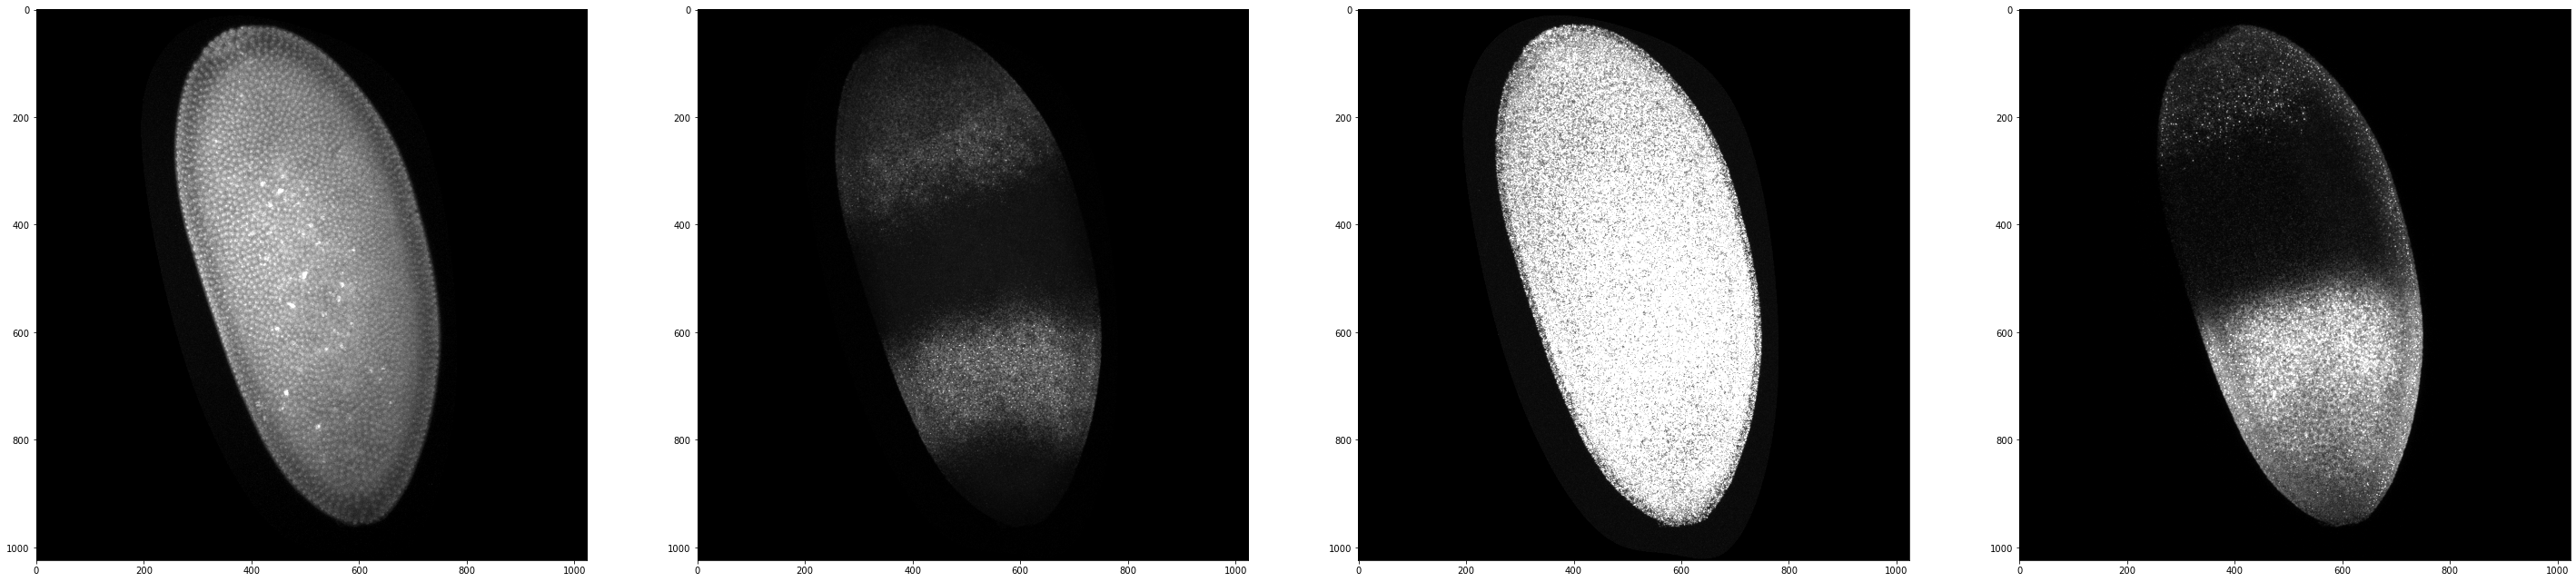

In [12]:
#create max projection. to make MIP you need to make sure you are only in 1 channel (the code above)
max_projection_DAPI = img_DAPI.max(0)
max_projection_gt = img_gt.max(0)
max_projection_pho = img_pho.max(0)
max_projection_hb = img_hb.max(0)

fig = plt.figure(figsize=(50,150))
ax=fig.add_subplot(1,4,1)
plt.imshow(max_projection_DAPI, cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,2)
plt.imshow(max_projection_gt, cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,3)
plt.imshow(max_projection_pho, cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,4)
plt.imshow(max_projection_hb, cmap='gray', vmin=bkgd_signal, vmax=max_signal)


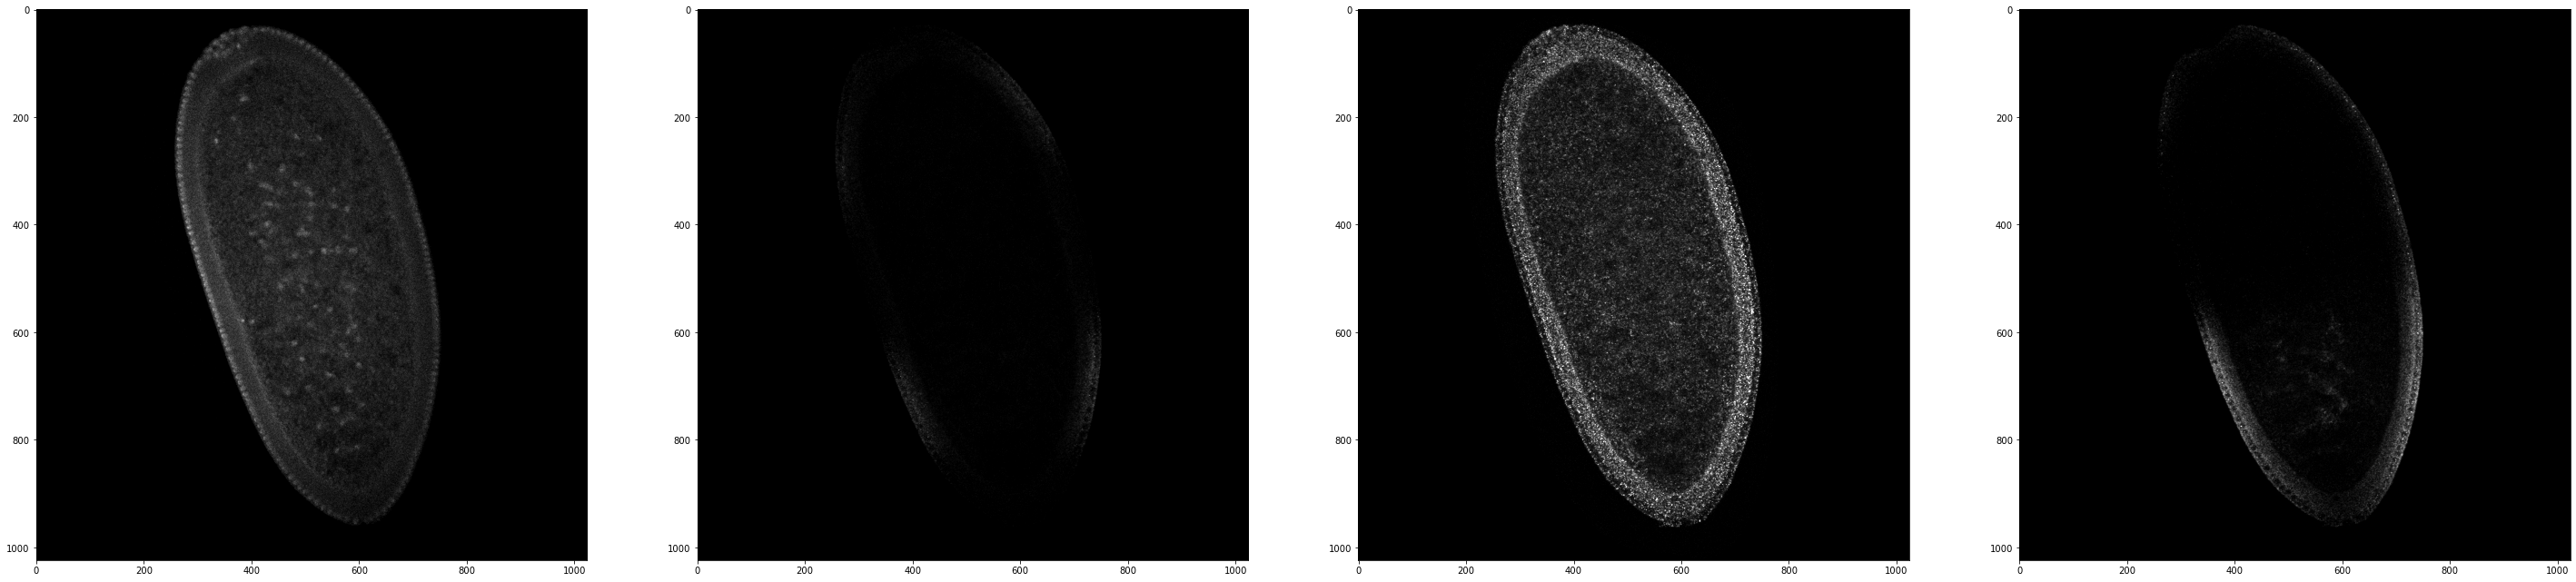

In [13]:
fig = plt.figure(figsize=(50,50))
ax=fig.add_subplot(1,4,1)
plt.imshow(img_DAPI[archer,:,:], cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,2)
plt.imshow(img_gt[archer,:,:], cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,3)
plt.imshow(img_pho[archer,:,:], cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,4)
plt.imshow(img_hb[archer,:,:], cmap='gray', vmin=bkgd_signal, vmax=max_signal)

saggital_DAPI = img_DAPI[archer,:,:]
saggital_snail = img_hb[archer,:,:]



In [14]:
normalized = exposure.adjust_gamma(saggital_DAPI)
hysterics = filters.apply_hysteresis_threshold(normalized, bkgd_signal, np.max(normalized)-1)
closed=morphology.binary_closing(hysterics)

In [15]:
edges = canny(closed, sigma=2.0, low_threshold=0.55, high_threshold=0.8) 


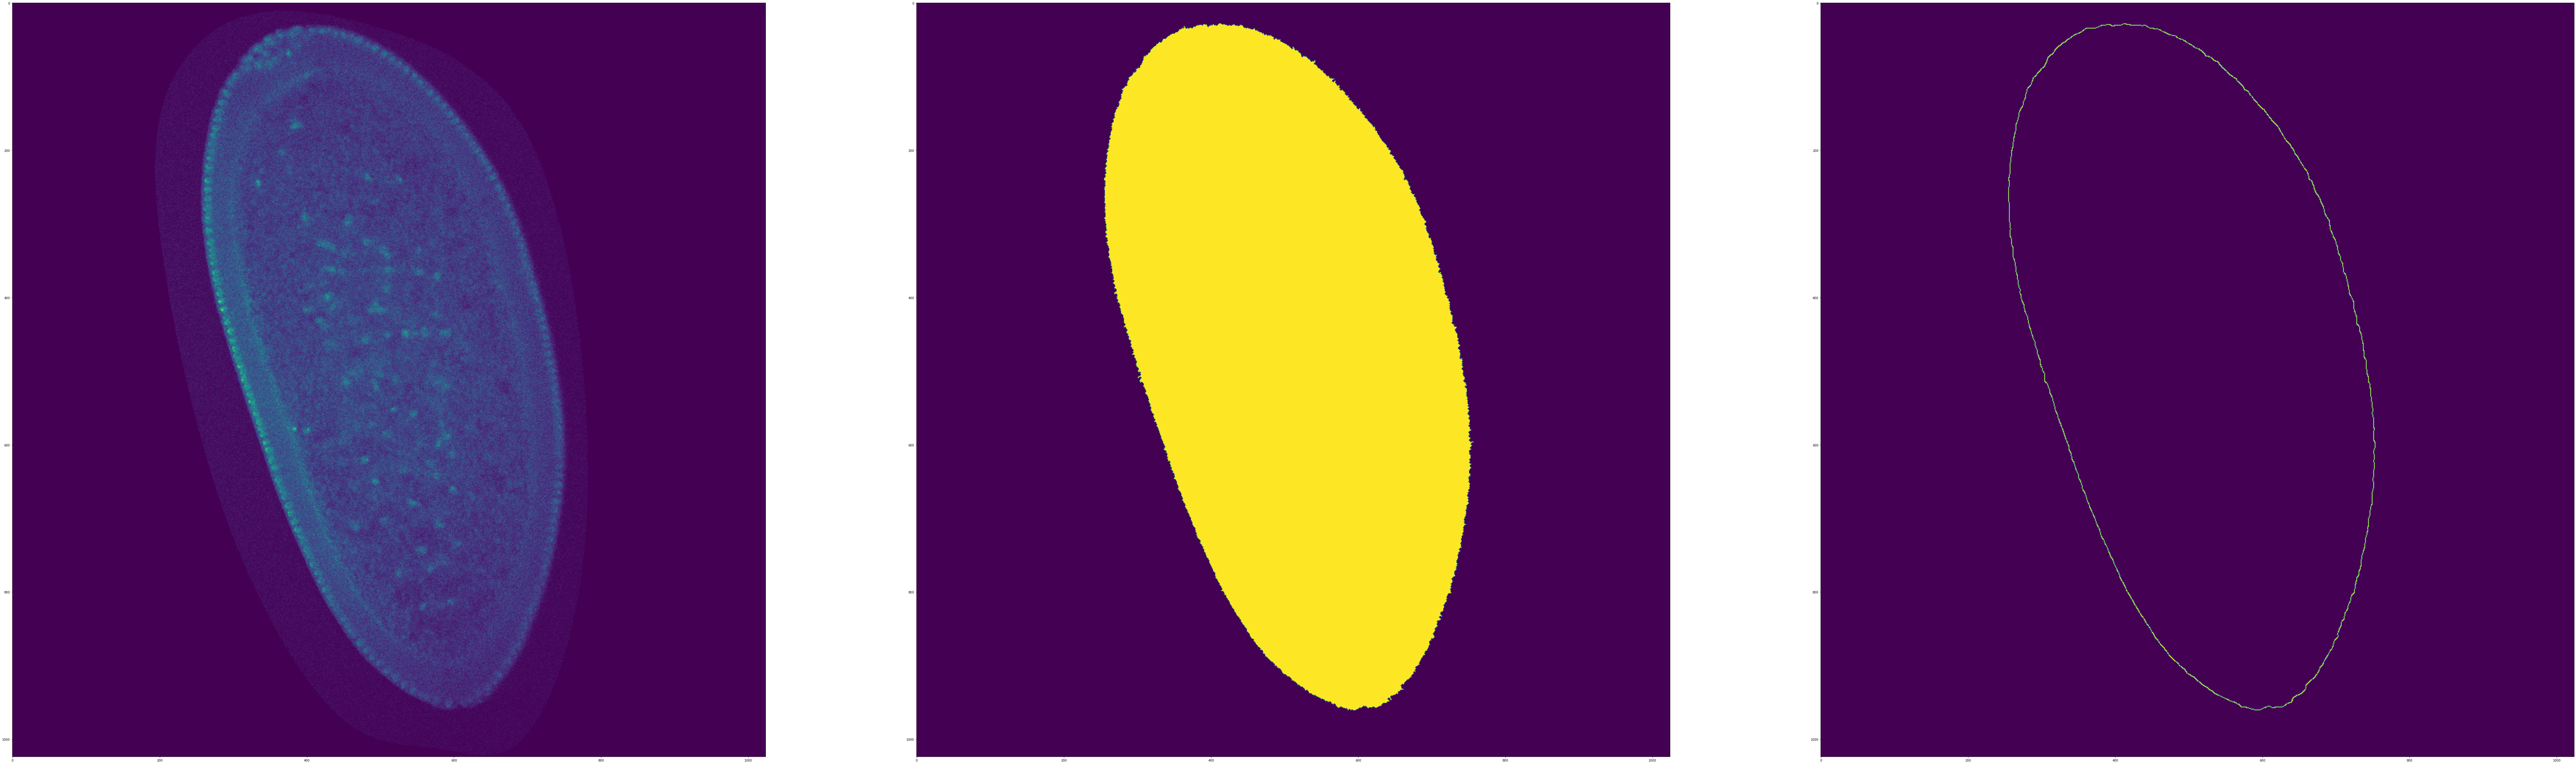

In [16]:
fig = plt.figure(figsize=(150,150))
ax=fig.add_subplot(1,3,1)
plt.imshow(normalized)
ax=fig.add_subplot(1,3,2)
plt.imshow(closed)
ax=fig.add_subplot(1,3,3)
plt.imshow(edges)



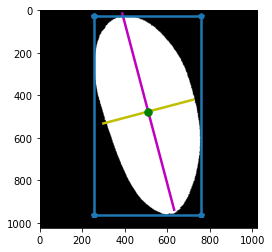

956.0706411843021


In [17]:
emb_label= label(closed.astype(np.uint8))
emb_regions = regionprops(closed.astype(np.uint8))

fig, ax = plt.subplots()
ax.imshow(closed, cmap=plt.cm.gray)

for props in emb_regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    long_axis = props.major_axis_length
    short_axis = props.minor_axis_length
    minr, minc, maxr, maxc = props.bbox

    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length #top
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x3 = x0 - math.cos(orientation) * 0.5 * props.minor_axis_length #bottom
    y3 = y0 + math.sin(orientation) * 0.5 * props.minor_axis_length
    
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length
    x4 = x0 + math.sin(orientation) * 0.5 * props.major_axis_length
    y4 = y0 + math.cos(orientation) * 0.5 * props.major_axis_length


ax.plot((x3, x1), (y3, y1), '-y', linewidth=2.5) #minor axis line
ax.plot((x4, x2), (y4, y2), '-m', linewidth=2.5) #major axis line
ax.plot(x0, y0, '.g', markersize=15)

bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-p', linewidth=2.5)

plt.show()

print(long_axis)

In [18]:
emb_props = regionprops_table(emb_label, properties=('centroid', 'orientation', 'major_axis_length', 'minor_axis_length'))

pd.DataFrame(emb_props)


centroid-0  centroid-1  orientation  major_axis_length  minor_axis_length
0  476.124043  510.490196     0.258373         956.070641         436.982376

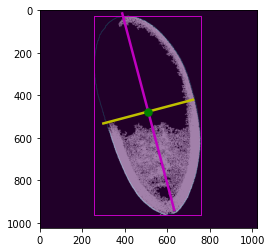

In [19]:
normalized_snail = exposure.adjust_gamma(saggital_snail)
hysterics_snail = filters.apply_hysteresis_threshold(normalized_snail, bkgd_signal, np.max(normalized)-1)

fig, ax = plt.subplots()
ax.imshow(hysterics_snail, cmap=plt.cm.gray)

ax.plot((x3, x1), (y3, y1), '-y', linewidth=2.5) #minor axis line
ax.plot((x4, x2), (y4, y2), '-m', linewidth=2.5) #major axis line
ax.plot(x0, y0, '.g', markersize=15)

bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-m', linewidth=1)

#np.max(hysterics_snail)
ax.imshow(edges, alpha=0.5) #rgba look into for transparency



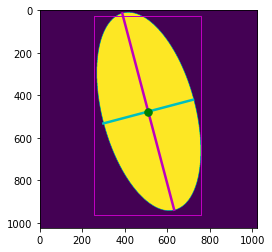

In [20]:
major_rad=long_axis/2
minor_rad=short_axis/2
oval = np.zeros((1024, 1024), dtype=np.uint8)
rr, cc = draw.ellipse(y0, x0, major_rad, minor_rad, rotation=orientation)
#rr, cc = draw.ellipse_perimeter(int(y0), int(x0), int(minor_rad), int(major_rad), orientation=orientation, shape=None)

oval[rr,cc]=1


fig, ax = plt.subplots()
ax.plot((x3, x1), (y3, y1), '-c', linewidth=2.5) #minor axis line
ax.plot((x4, x2), (y4, y2), '-m', linewidth=2.5) #major axis line
ax.plot(x0, y0, '.g', markersize=15)

bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-m', linewidth=1)

#np.max(hysterics_snail)
#ax.imshow(edges, alpha=0.15)

plt.imshow(oval)
# plt.imshow(np.fliplr(oval))
#plt.plot(rr,cc)

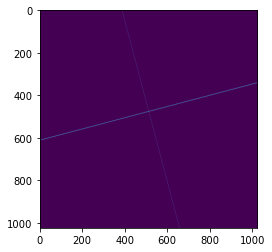

In [21]:
minor_axis_line = np.zeros((1024, 1024), dtype=bool)
major_axis_line = np.zeros((1024, 1024), dtype=bool)

m_minor = (y1 - y0) / (x1 - x0)
b_minor = (y1 - (m_minor * x1))
m_major = (y2 - y0) / (x2 - x0)
b_major = (y2 - (m_major * x2))

# minor axis loop
minor_inds = []
for x in range(minor_axis_line.shape[1]):
    y = ((m_minor * x) + b_minor)
    if y < minor_axis_line.shape[1] and y >= 0:
        minor_axis_line[int(y),int(x)] = True
        minor_inds.append((int(y), (int(x))))

# major axis loop
major_inds = [] # list
for x in range(major_axis_line.shape[0]):
    y = ((m_major * x) + b_major)
    if y < major_axis_line.shape[0] and y >= 0:
        major_axis_line[int(y),int(x)] = True
        major_inds.append([int(y), int(x)])


fig, ax = plt.subplots()
ax.imshow(minor_axis_line + major_axis_line)

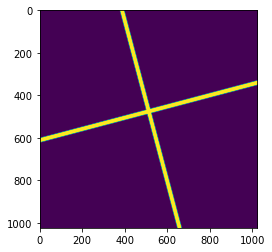

In [22]:
footprint=morphology.disk(10)

major_axis_knife = morphology.binary_dilation(major_axis_line, footprint)
minor_axis_knife = morphology.binary_dilation(minor_axis_line, footprint)

fig, ax = plt.subplots()
ax.imshow(minor_axis_knife + major_axis_knife)

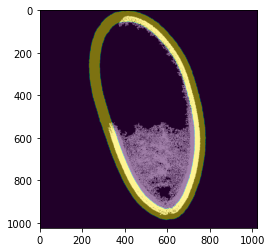

In [23]:
#dialation of edges
footprint=morphology.disk(25)
dil1 = morphology.binary_dilation(edges, footprint)
fig, ax = plt.subplots()
ax.imshow(hysterics_snail, cmap=plt.cm.gray)
ax.imshow(dil1, alpha=0.5)

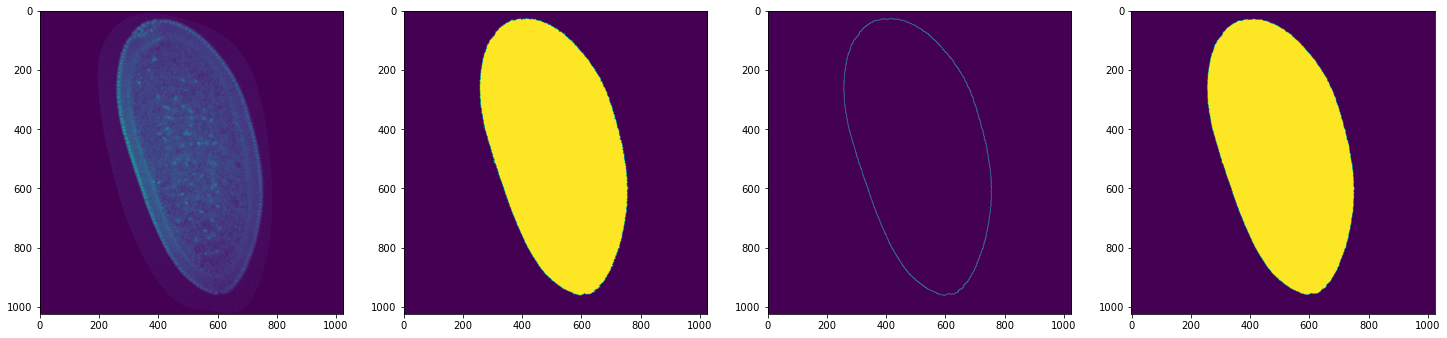

In [24]:
#cleaning up the closed circle
# 
dilated_edge=morphology.binary_dilation(edges) # fills a hole in edges

better_closed = morphology.flood(dilated_edge, (int(y0), int(x0)))

fig = plt.figure(figsize=(25,25))
ax=fig.add_subplot(1,4,1)
plt.imshow(normalized)
ax=fig.add_subplot(1,4,2)
plt.imshow(closed)
ax=fig.add_subplot(1,4,3)
plt.imshow(edges)
ax=fig.add_subplot(1,4,4)
plt.imshow(better_closed)

bool


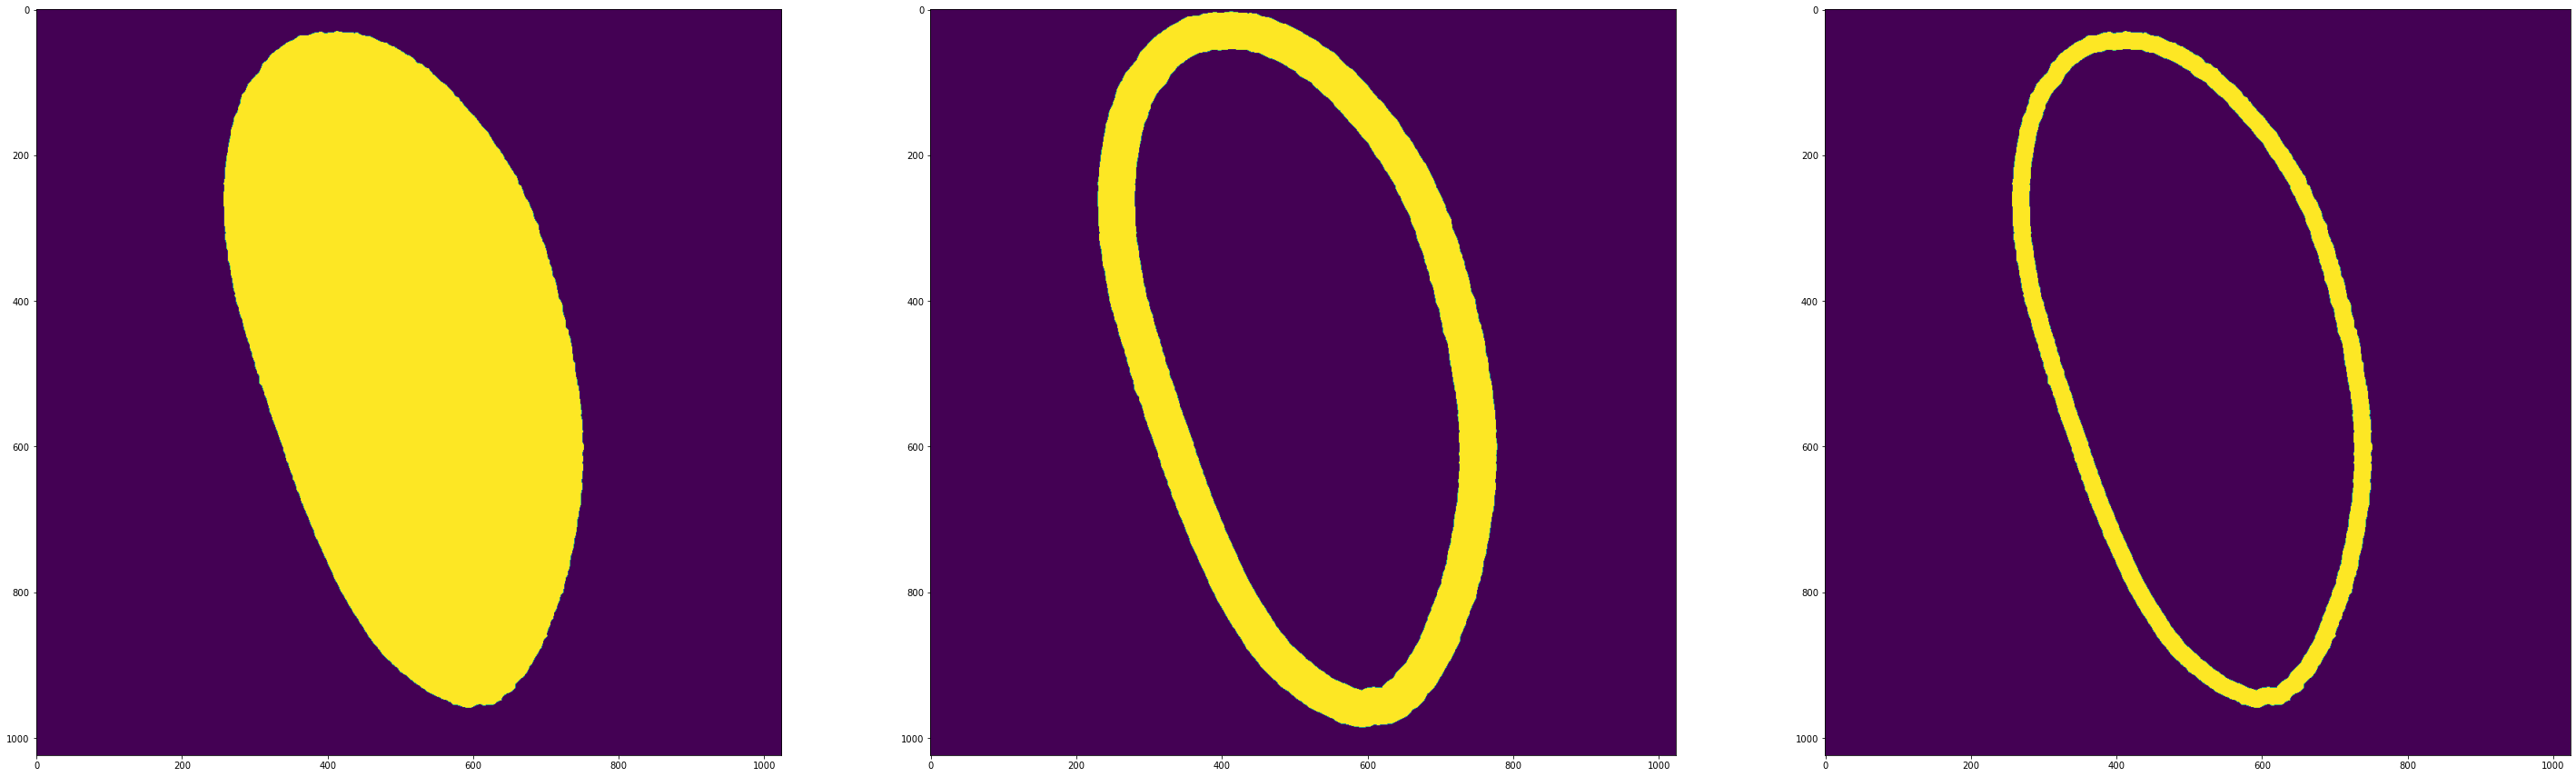

In [25]:
zorro=better_closed*dil1

fig, ax = plt.subplots(1,3, figsize=(50,150))
ax[0].imshow(better_closed)
ax[1].imshow(dil1)
ax[2].imshow(zorro)

print(zorro.dtype)

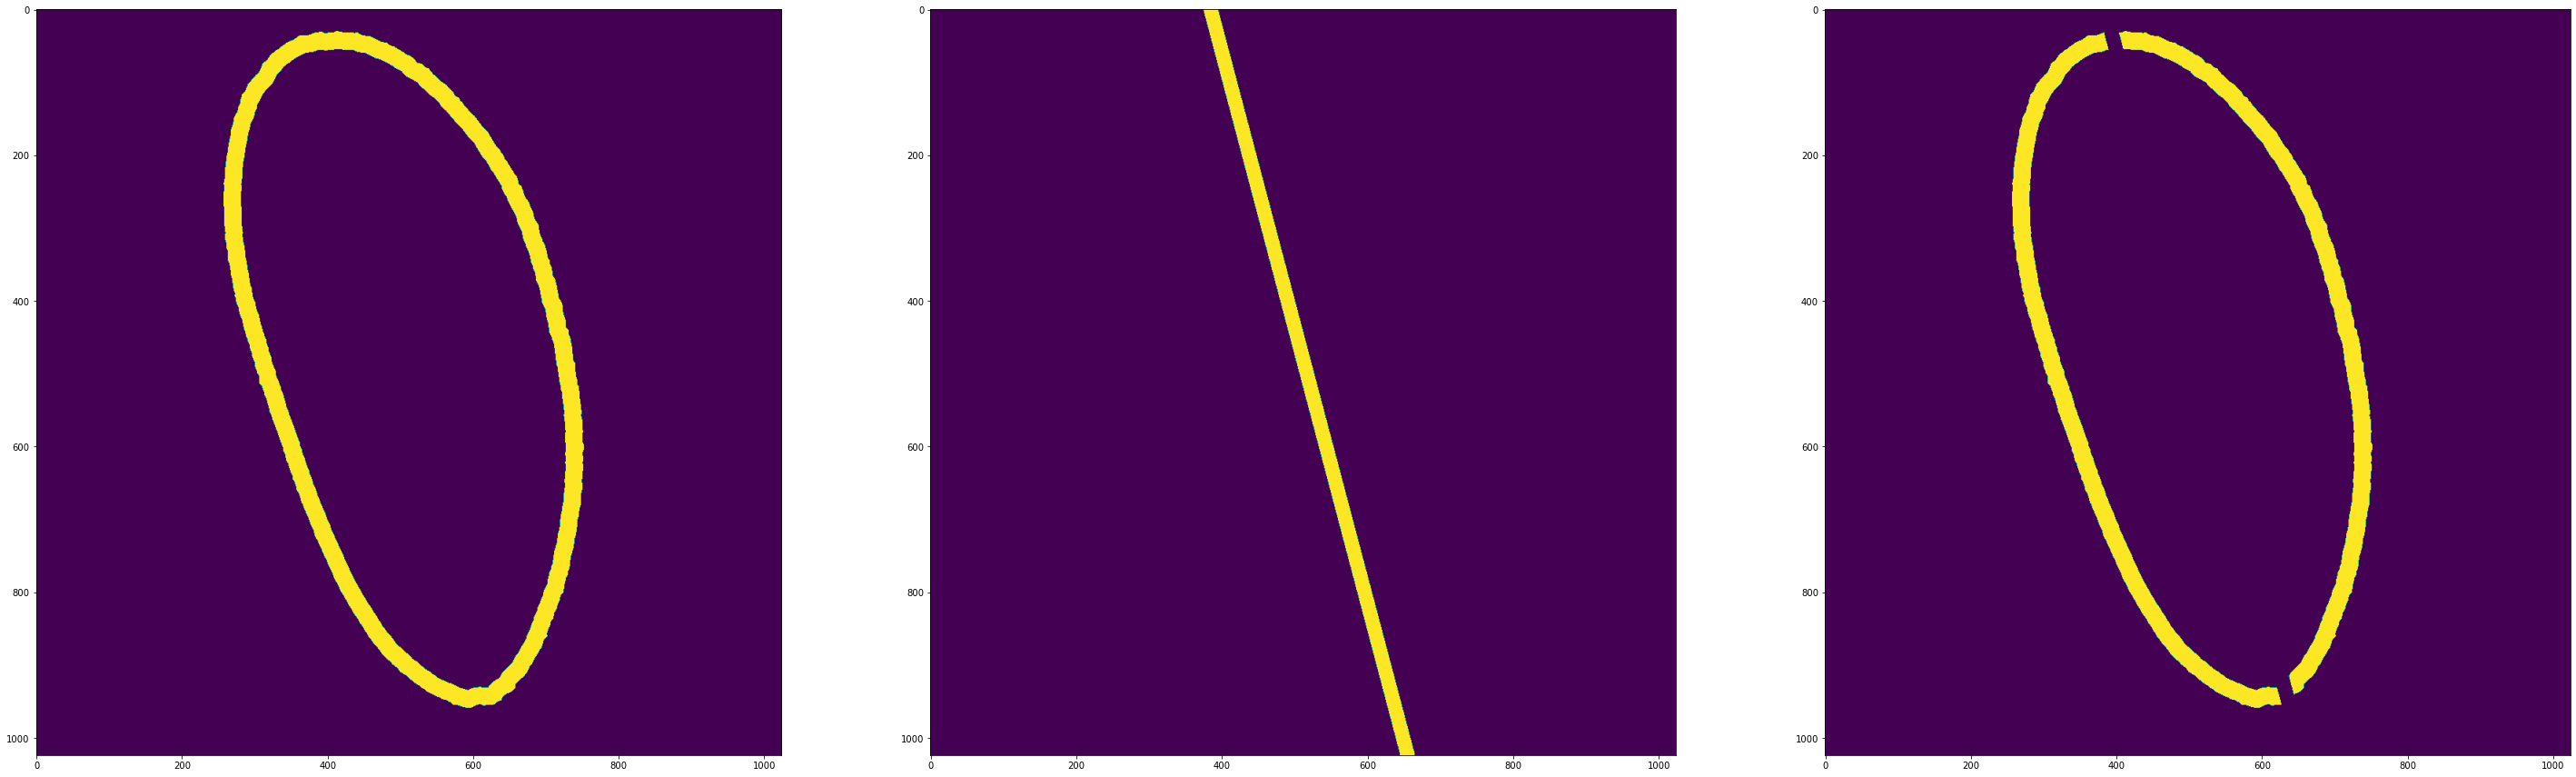

In [26]:
dv_divide = np.invert(major_axis_knife) * zorro

fig, ax = plt.subplots(1,3, figsize=(50,150))
ax[0].imshow(zorro)
ax[1].imshow(major_axis_knife)
ax[2].imshow(dv_divide)


In [27]:
dv_label = label(dv_divide)
dv_regions = regionprops(dv_label)

dv_props = regionprops_table(dv_label, properties=('area', 'perimeter', 'bbox'))
pd.DataFrame(dv_props)


area    perimeter  bbox-0  bbox-1  bbox-2  bbox-3
0  25421  2289.961687      30     404     941     752
1  26277  2377.222618      32     257     959     627

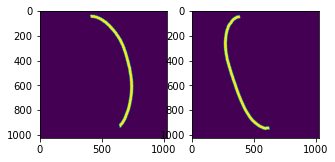

In [28]:
blank = np.zeros((1024,1024), dtype=bool)

sideA = blank.copy()
bbox = dv_regions[0].bbox
sideA[bbox[0]:bbox[2], bbox[1]:bbox[3]] = dv_regions[0].image

sideB = blank.copy()
bbox = dv_regions[1].bbox
sideB[bbox[0]:bbox[2], bbox[1]:bbox[3]] = dv_regions[1].image

fig, ax = plt.subplots(1,2, figsize=(5,5))
ax[0].imshow(sideA)
ax[1].imshow(sideB)

In [29]:
sideA.dtype

dtype('bool')

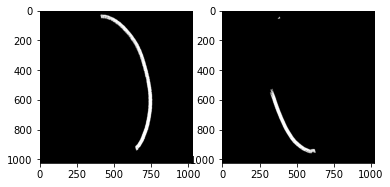

In [30]:
decide_A = hysterics_snail*sideA
decide_B = hysterics_snail*sideB

fig, ax = plt.subplots(1,2)
ax[0].imshow(decide_A, cmap=plt.cm.gray)
ax[1].imshow(decide_B, cmap=plt.cm.gray)

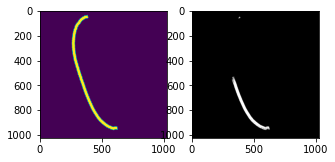

In [31]:
if np.sum(decide_A) > np.sum(decide_B):
    dorsal = sideB
    dorsal_check = decide_B
else:
         dorsal = sideA
         dorsal_check = decide_A


fig, ax = plt.subplots(1,2, figsize=(5,5))
ax[0].imshow(dorsal)
ax[1].imshow(dorsal_check, cmap=plt.cm.gray)

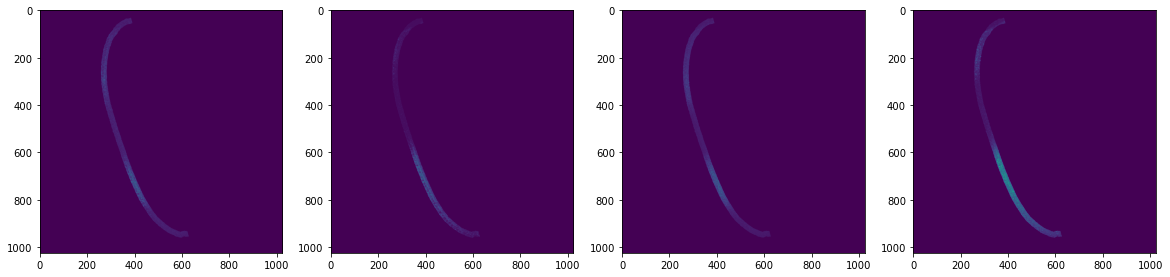

In [32]:
dorsal_gt_signal = dorsal * img_gt[archer,:,:]
dorsal_hb_signal = dorsal * img_hb[archer,:,:]
gt_signal_max = dorsal * max_projection_gt
hb_signal_max = dorsal *max_projection_hb

fig, ax = plt.subplots(1,4, figsize=(20,20))
ax[0].imshow(dorsal_gt_signal)
ax[1].imshow(dorsal_hb_signal)
ax[2].imshow(gt_signal_max)
ax[3].imshow(hb_signal_max)

In [30]:
# # i have to rotate it. 
# plt.imsave('dorsal_gt_signal.png', dorsal_gt_signal)
# plt.imsave('dorsal_hb_signal.png', dorsal_hb_signal)

In [31]:
# from PIL import Image
 
# # Giving The Original image Directory
# # Specified
# hb_signal = Image.open("dorsal_hb_signal.png")
 
# # Rotate Image By 180 Degree
# rotated_image1 = hb_signal.rotate(180)
 
# # This is Alternative Syntax To Rotate
# # The Image
# # rotated_image2 = hb_signal.transpose(Image.ROTATE_90)
 
# # This Will Rotate Image By 60 Degree
# rotated_image3 = hb_signal.rotate(60)
 
# rotation_axis = 90 - (orientation * 180/math.pi)
# rotated_hb = hb_signal.rotate(rotation_axis)
# rotated_hb2 = np.flip(rotated_hb)

 
# fig, ax = plt.subplots(1,4, figsize=(20,20))
# ax[0].imshow(rotated_image1, cmap=plt.cm.gray)
# ax[1].imshow(rotated_image3, cmap=plt.cm.gray)
# ax[2].imshow(rotated_hb, cmap=plt.cm.gray)
# ax[3].imshow(rotated_hb2, cmap=plt.cm.gray)



In [33]:
print(dorsal.dtype)

bool


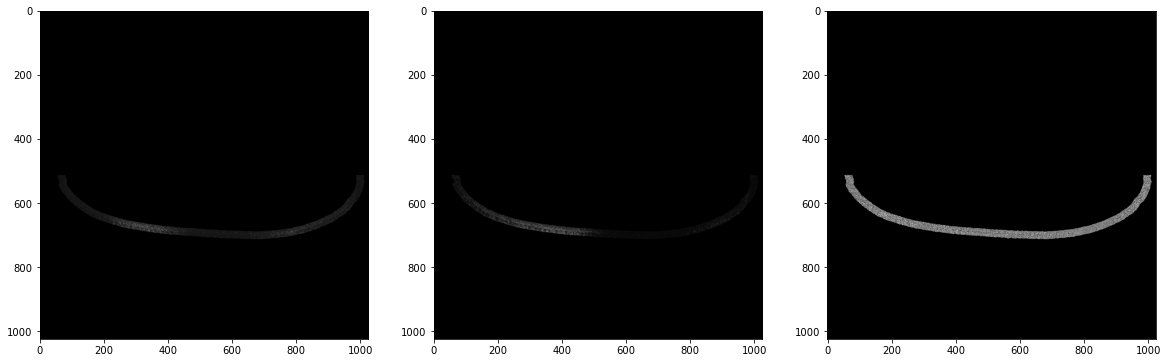

In [34]:
from scipy import ndimage, misc
rotation_axis = 90 - (orientation * 180/math.pi)

rotate_gt = ndimage.rotate(dorsal_gt_signal, rotation_axis, reshape=False)
rotate_gt = np.fliplr(rotate_gt)

rotate_hb = ndimage.rotate(dorsal_hb_signal, rotation_axis, reshape=False)
rotate_hb = np.fliplr(rotate_hb)

rotate_dorsal_mask = ndimage.rotate(dorsal, rotation_axis, reshape=False)
rotate_dorsal_mask = np.fliplr(rotate_dorsal_mask) 

fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(rotate_gt, cmap=plt.cm.gray)
ax[1].imshow(rotate_hb, cmap=plt.cm.gray)
ax[2].imshow(rotate_dorsal_mask, cmap=plt.cm.gray)

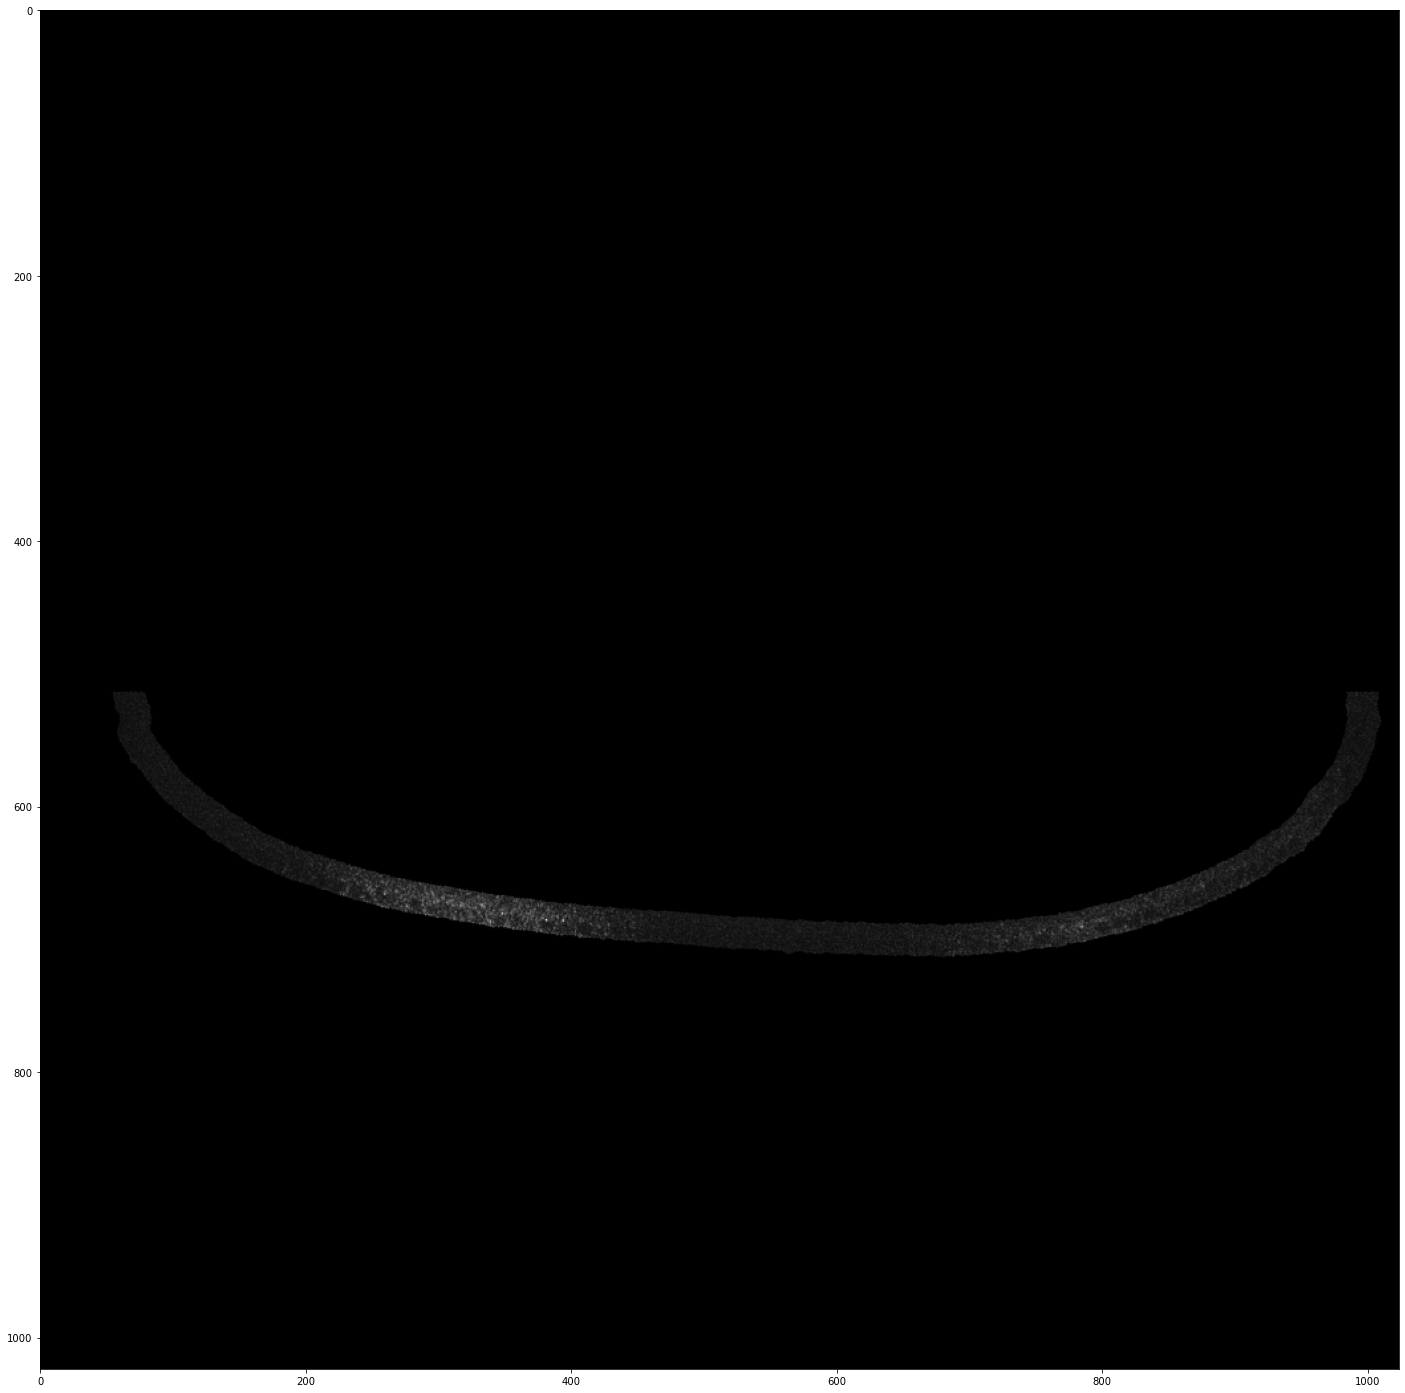

In [35]:
fig, ax = plt.subplots(figsize=(25,25))
plt.imshow(rotate_gt, cmap=plt.cm.gray)

/var/folders/8g/xxkf18yx5b9fx5rg19w8b75h0000gn/T/ipykernel_21168/261658620.py:10: RuntimeWarning: invalid value encountered in true_divide
  gt_mean_trace = gt_sum_trace / mask_sum
/var/folders/8g/xxkf18yx5b9fx5rg19w8b75h0000gn/T/ipykernel_21168/261658620.py:11: RuntimeWarning: invalid value encountered in true_divide
  hb_mean_trace = hb_sum_trace / mask_sum


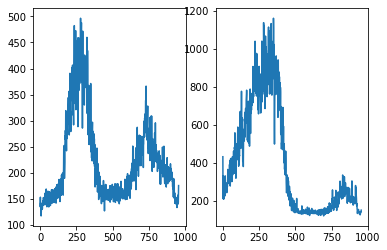

In [36]:
masked_rotate_gt = rotate_gt * rotate_dorsal_mask
    #gt_max_trace = masked_rotate_gt.max(axis=0) #doesn't look good enough. choosing mean. 
gt_sum_trace = masked_rotate_gt.sum(axis=0)

masked_rotate_hb = rotate_hb * rotate_dorsal_mask
hb_sum_trace = masked_rotate_hb.sum(axis=0)

mask_sum = rotate_dorsal_mask.sum(axis=0)

gt_mean_trace = gt_sum_trace / mask_sum
hb_mean_trace = hb_sum_trace / mask_sum

trace_gt = gt_mean_trace[mask_sum>0]
trace_hb = hb_mean_trace[mask_sum>0]

fig, ax = plt.subplots(1,2)
ax[0].plot(trace_gt)
ax[1].plot(trace_hb)

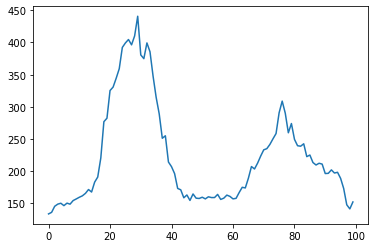

In [44]:
import scipy.stats as stats
x = np.arange(trace_gt.shape[0])
standard_trace, _, _ = stats.binned_statistic(x, trace_gt, bins=100)
plt.plot(standard_trace)

In [ ]:
# masked_rotate_gt = rotate_hb * rotate_dorsal_mask
# gt_max_trace = masked_rotate_gt.max(axis=0)
# #gt_median_trace = rotate_gt.median(axis=0)
# gt_sum_trace = masked_rotate_gt.sum(axis=0)
# mask_sum = rotate_dorsal_mask.sum(axis=0)

# gt_mean_trace = gt_sum_trace / mask_sum

# fig, ax = plt.subplots(1,3)
# ax[0].plot(gt_max_trace[mask_sum>0])
# ax[1].plot(gt_sum_trace[mask_sum>0])
# ax[2].plot(gt_mean_trace[mask_sum>0])

# trace_gt = gt_mean_trace[mask_sum>0

In [ ]:
from scipy import interpolate

dorsal_max_traces_spline = interpolate.splrep(0:dorsal_gt_signal.shape[1], dorsal_max_traces, k = 3, s = 1)
y_int = interpolate.splev(x_int, tck, der = 0)

271


In [ ]:
import pandas as pd

data = [dorsal_max_traces]

smoothendData = pd.rolling_mean(data,5)
#this could work if you make a dataframe out of your data then do {that_dataframe}.rolling(window_size)

AttributeError: module 'pandas' has no attribute 'rolling_mean'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import gaussian_process

data = dorsal_max_traces
x = np.zeros(len(dorsal_max_traces))
y = data
x_pred = np.linspace(x[0], x[-1], 100)

# <GP regression>
gp = sklearn.gaussian_process.GaussianProcessRegressor(theta0=1, thetaL=0.00001, thetaU=1000, nugget=0.000001)
gp.fit(np.atleast_2d(x).T, y)
y_pred = gp.predict(np.atleast_2d(x_pred).T)
# </GP regression>

TypeError: __init__() got an unexpected keyword argument 'theta0'

## How to fit all embryos (and embryo slices) onto a standard AP (0-100 %) axis. 

I realized that I am going to need to standardize the extracted pattern (however I end up extracting the pattern above, be it through rotating and flattening or by using the perpindicular to the major axis). 

This can be done by applying a quantized histogram to the data (0-1000 bins) and fitting the numpy array into a quantized format. 

Otherwise, I wonder if there is a way to standardize as a percentage? Like if one embryo is say 2089 and another is 3048, could you divide the x into percentages? I guess that would be more difficult for the parsing as there would need to be a fixed number (integers) for the x to make it easier to graph...so never mind.

This is a note for monday as friday I did fly work and shot the shit with coworkers. Cheers!

In [ ]:
#cell1 (ran once):
#   make (filename_list)
#   i = 0
#   initialize data file or object for outputs
#cell2 (will be rerun):
#   data = load(filename_list[i])
#   ...
#   display data with labeled points (labeled 0 or 1) #make them color points with red = 0 and green = 1
#cell3 (will be rerun):
#   anterior = {manually set to 0 or 1 depending on embryo}
#cell4 (will be rerun):
#   process with info about anterior/posterior axis
#   append to data file (or object)
#   i += 1 #set to run the next file in the list and rerun from cell 2
#   if i >= len(filename_list): print("You're done!!") # so you don't get carried away


In [ ]:
# using the mask, segment the boundaries of the embryo

#skimage.morphology.disk(1024)
#mask_DAPI = max_projection_DAPI > 500
# boat=skimage.morphology.convex_hull_image(img_DAPI>500)

# maybe





# ax=fig.add_subplot(1,2,2)
# plt.imshow(saggitarius_gt, cmap='gray', vmin=110, vmax=4000)

# fig, ax = plt.subplots(1,2,figsize=(50,50))
# ax.contour(boat)

# find the plane with the largest ellipse and extract plane for future analysis

# extract planes +/- 3 from 'center' plane. save for future analysis

In [ ]:
# create a box (size tbd) that will run perpindicular to the ventral long axis

# extract channel signal from the box

In [ ]:
# run box along the three planes (center_plane, upper_bound, lower_bound)

# average traces between the three planes

# stats on the 3 traces to ensure no outliers

# plot average trace from each channel